In [1]:
# Initialization code for 1.8 V SiGe PMOS LDO Testing. 
# Adapted by Shawn for PMOS_LDO from Langdon's code for NPN_LVR (which was based off Sean's code)
# This block identifies and initializes the connected SMUs (Source Measure Units).

import pyvisa                    # Instrument communication
import time                      # Handle time-related tasks (e.g., delays)
import matplotlib.pyplot as plt  # Plotting graphs and visualizing data
import numpy as np               # Numerical operations, particularly with arrays
import pandas as pd              # Data manipulation and analysis
import os                        # Interact with the operating system, such as handling file paths
import csv                       # Read from and write to CSV files
from datetime import date        # Read current date
from collections import defaultdict

In [14]:
VIN_MAX=33
VIN_STEP=1
VIN_MIN=11
ILMAX=-.01
VIN=[]
ITOT=[]
VOUT=[]
ILset=.003      # This is the load current to aim for
Rhi=330
Rlo=68000

VREFdef = 2

VREFlist = [0.8, 1.2, 1.6, 2.0, 2.4]
TEMPlist = [125, 100, 75, 50, 25,  0, -25, -50, -75, -100, -125, -150, -175]      # List of temperatures for test
TempsToTest = TEMPlist
ILlist = [50E-6, 100E-6, 300E-6, 500E-6, 1E-3, 2E-3, 3E-3, 4E-3, 5E-3, 6E-3, 7E-3, 8E-3, 9E-3, 10E-3]
ILlistmA= [num * 1000 for num in ILlist]

In [3]:
# Determine the appropriate scaling for generated plots in Engineering Notation
def scale(list):
    array = np.asarray(list, dtype='float') # Python doesn't support multiplying a list by a float. Numpy does.
    if np.max(np.abs(array)) < 1e-9:
        k = 1e12
    elif np.max(np.abs(array)) < 1e-6:
        k = 1e9
    elif np.max(np.abs(array)) < 1e-3:
        k = 1e6
    elif np.max(np.abs(array)) < 1:
        k = 1e3
    else:
        k = 1
    
    return k*array # Return the scaled array

# Determine the appropriate prefix for arrays that use scale(). USE ORIGINAL LIST, NOT THE SCALED
def prefix(list):
    array = np.asarray(list, dtype='float')
    if np.max(np.abs(array)) < 1e-9:
        k = 1e12
        prefix = 'p'
    elif np.max(np.abs(array)) < 1e-6:
        k = 1e9
        prefix = 'n'
    elif np.max(np.abs(array)) < 1e-3:
        k = 1e6
        prefix = 'µ'
    elif np.max(np.abs(array)) < 1:
        k = 1e3
        prefix = 'm'
    else:
        k = 1
        prefix = ''

    return prefix

In [5]:
def start_plot(title, xlabel, ylabel):
    # Create a color map for the plots
    cm=plt.get_cmap('gist_rainbow')

    # Apply default parameters that are shared by all plots. Any property can be changed afterwards if needed.
    fig, plot = plt.subplots(layout='constrained')
    plot.set_title(title, fontdict={'fontsize': 16, 'fontweight': 'bold'}, y = 1.03)
    plot.set_xlabel(xlabel, fontdict={'fontsize': 12})
    plot.set_ylabel(ylabel, fontdict={'fontsize': 12})
    plot.tick_params(axis='both', which='major', labelsize=10)
    plot.set_prop_cycle ('color', [cm(1.*i/len(TEMPlist)) for i in range(len(TEMPlist))])
    plot.grid()
    return fig, plot

# Below - plot, fig, directory, and name are POSITIONAL arguments - when calling function, must insert those first and in
# the same order. 'legend' and 'close' are KEYWORD arguments - when calling function, their order does not matter (as long
# as they come after the positional), but you must write out the name and '=' for each. Keyword arguments are optional. 
# If not provided, the default values in the definition below (True) will be assumed.
def finish_plot(plot, fig, directory, name, legend=True, close=True): 
    if (legend):
        for line in plot.legend(bbox_to_anchor=(1.02, 1), loc='upper left').get_lines(): # Creates legend
            line.set_linewidth(2.5) # Changes widths of the legend's example lines, NOT the actual lines on the plot
    if (close):
        plt.close(fig) #Saves memory, faster
    fig.savefig(os.path.join(directory, name))

(0.0, 10.0)

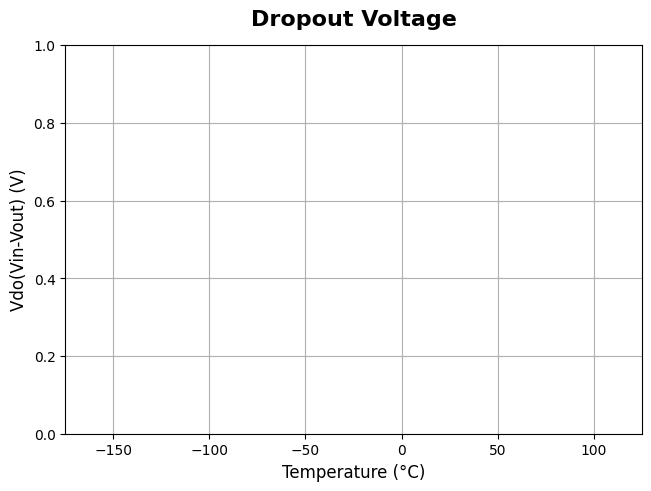

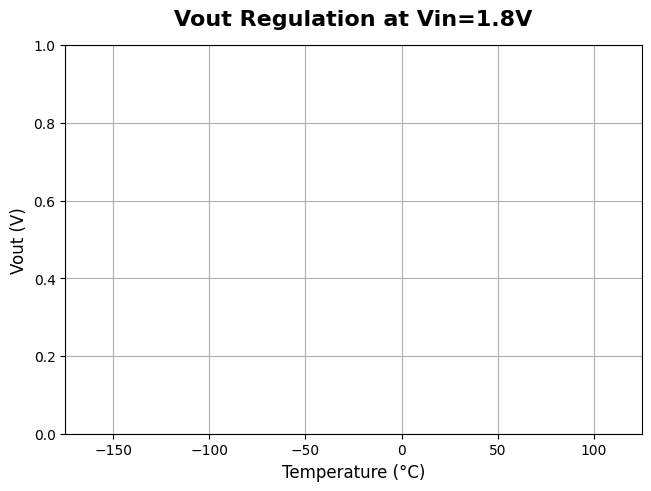

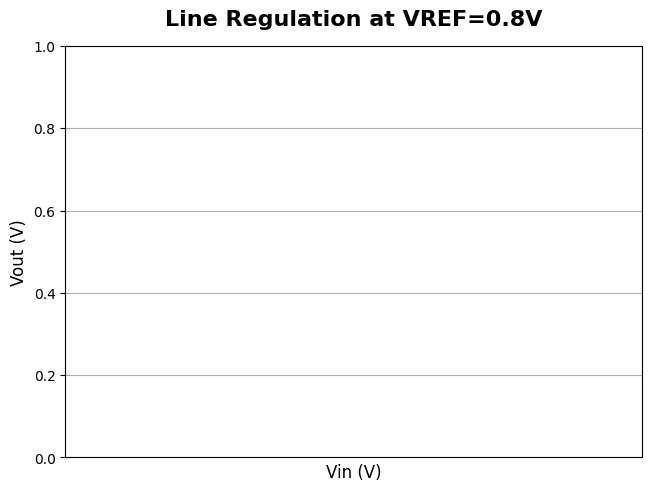

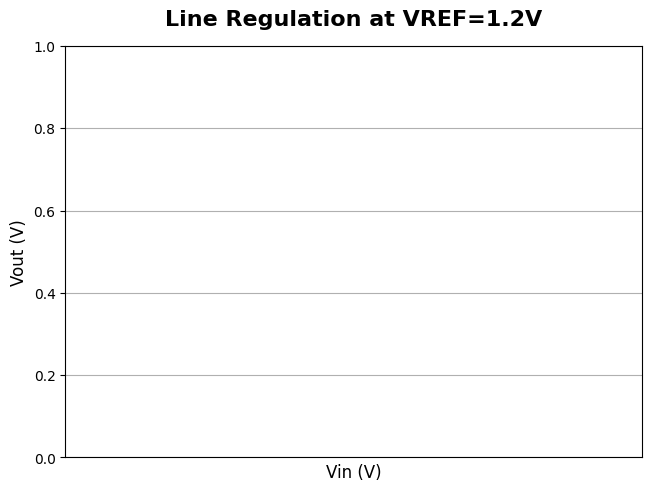

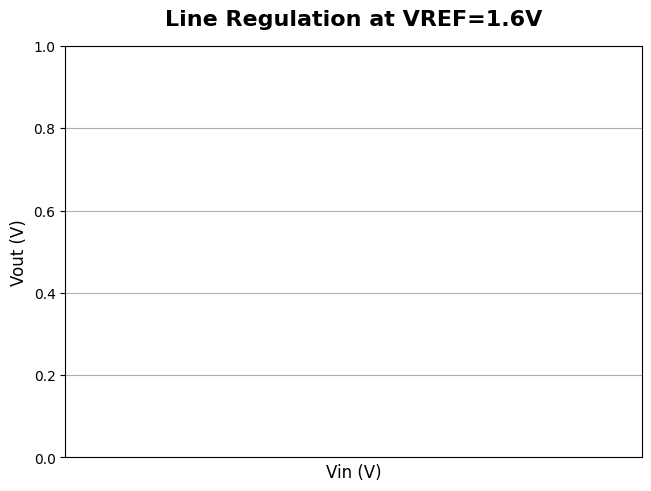

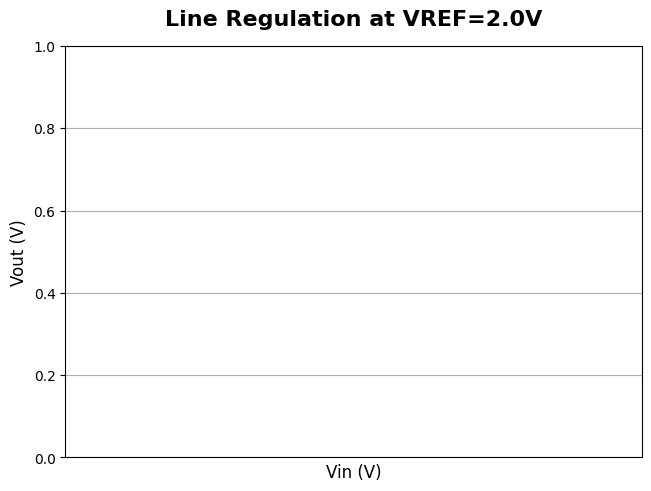

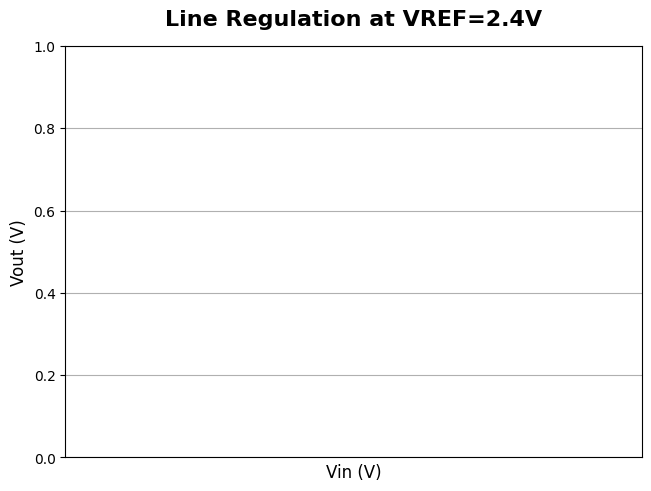

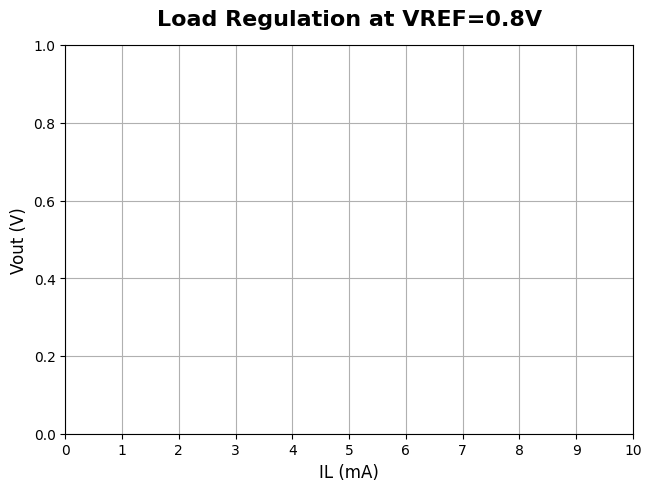

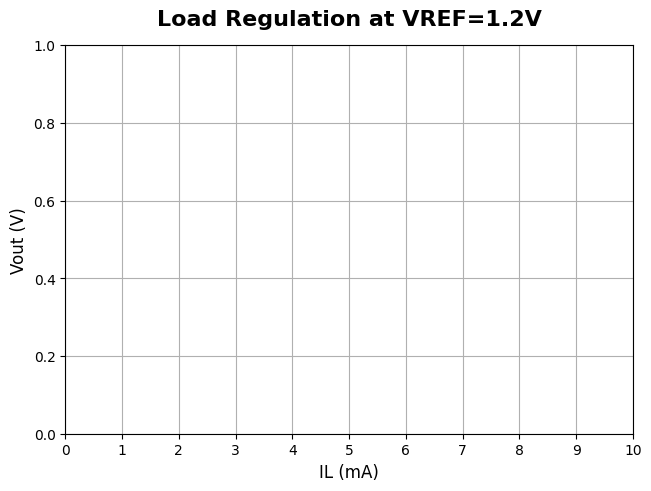

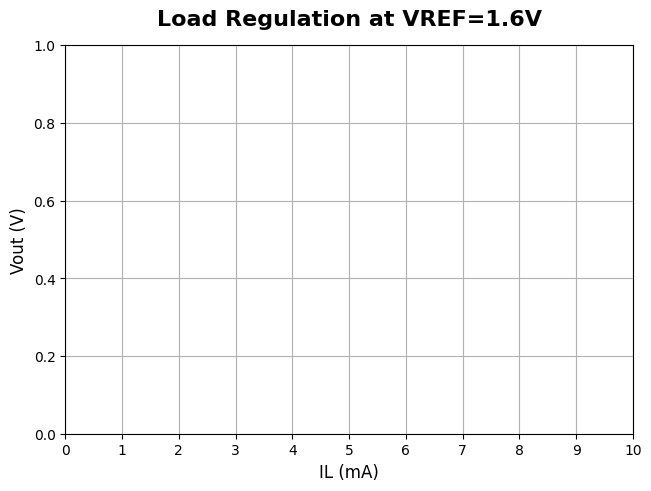

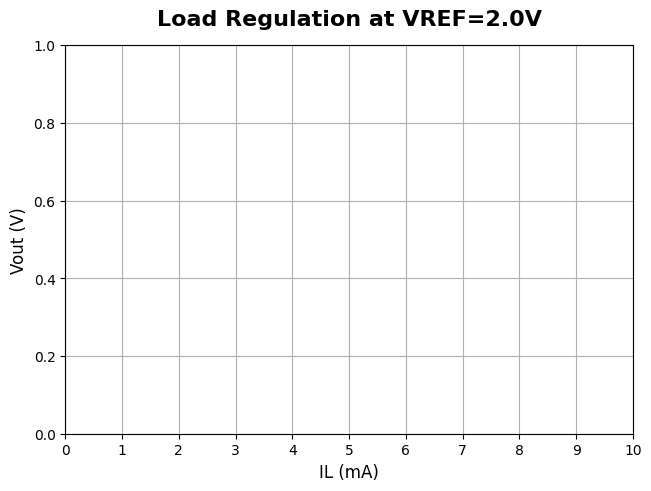

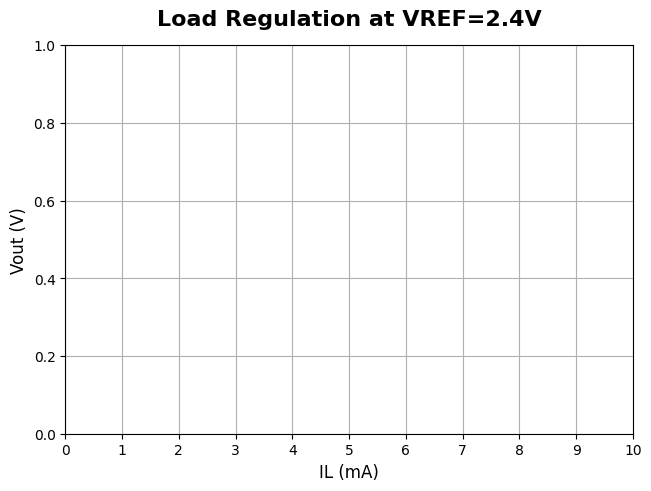

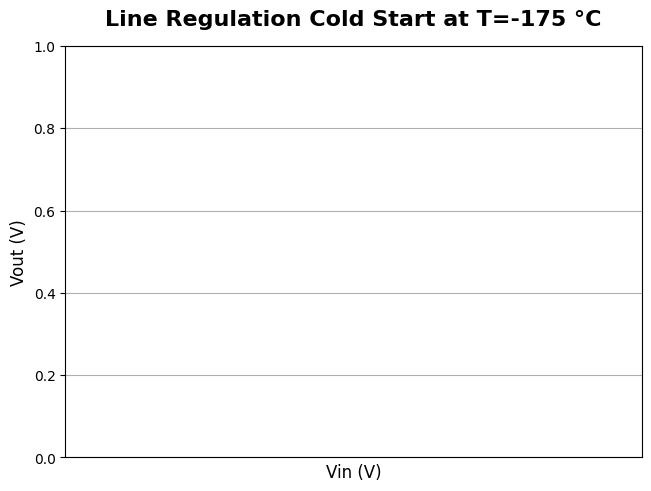

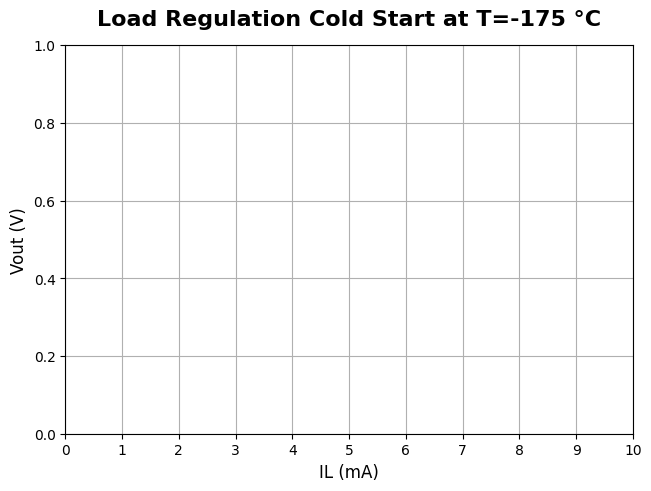

In [7]:
################## Initialize and format plots ##################
    
# Dropout voltage plot
DVfig, DVplot = start_plot('Dropout Voltage', 'Temperature (°C)', 'Vdo(Vin-Vout) (V)')
DVplot.set_xticks(np.arange(-150, 150, 50))
DVplot.set_xlim(-175, 125)
#DVplot.set_yticks(np.arange(0, 1.3, 0.1))
#DVplot.set_ylim(-175, 125)

# Vout regulation plot
VRfig, VRplot = start_plot('Vout Regulation at Vin=1.8V', 'Temperature (°C)', 'Vout (V)')
VRplot.set_xticks(np.arange(-150, 150, 50))
VRplot.set_xlim(-175, 125)

# Create figures for the overall line regulation plots for each VREF
LineRplot = defaultdict(list)
LineRfig = defaultdict(list)
for VREF in VREFlist:
    LineRfig[VREF], LineRplot[VREF] = start_plot('Line Regulation at VREF='+str(VREF)+'V', 'Vin (V)', 'Vout (V)')
    LineRplot[VREF].set_xticks(np.arange(max(VIN_MIN, VREF), 1.8, 0.1))
    LineRplot[VREF].set_xlim(max(VIN_MIN, VREF), 1.8)

# Load regulation plot
LoadRplot = defaultdict(list)
LoadRfig = defaultdict(list)
for VREF in VREFlist:
    LoadRfig[VREF], LoadRplot[VREF] = start_plot('Load Regulation at VREF='+str(VREF)+'V', 'IL (mA)', 'Vout (V)')
    LoadRplot[VREF].set_xticks(np.arange(-1, 11, 1))
    LoadRplot[VREF].set_xlim(0, ILlistmA[-1])
    #LoadRplot.set_xscale("log")

# Cold Start Line regulation plot
ColdLineRfig, ColdLineRplot = start_plot('Line Regulation Cold Start at T=-175 °C', 'Vin (V)', 'Vout (V)')
ColdLineRplot.set_xticks(np.arange(max(VIN_MIN, VREF), 1.8, 0.1))
ColdLineRplot.set_xlim(max(VIN_MIN, VREF), 1.8)

# Cold Start Load regulation plot
ColdLoadRfig, ColdLoadRplot = start_plot('Load Regulation Cold Start at T=-175 °C', 'IL (mA)', 'Vout (V)')
ColdLoadRplot.set_xticks(np.arange(-1, 11, 1))
ColdLoadRplot.set_xlim(0, ILlistmA[-1])
#LoadRplot.set_xscale("log")

In [15]:
################## Save Overall Figures (From CSV) ##################

for VREF in VREFlist:
    finish_plot(LineRplot[VREF], LineRfig[VREF], RUN_DIR, "Line_Regulation_"+str(VREF)+"V.png")
    finish_plot(LoadRplot[VREF], LoadRfig[VREF], RUN_DIR, "Load_Regulation_"+str(VREF)+"V.png")
    DVplot.plot(TempsToTest, VDOdict[VREF], label="VREF="+str(VREF)+" (V)")
    VRplot.plot(TempsToTest, VOUTregdict[VREF], label="VREF="+str(VREF)+" (V)")

finish_plot(DVplot, DVfig, RUN_DIR, "Dropout_Voltage.png")
finish_plot(VRplot, VRfig, RUN_DIR, "Voltage_Regulation.png")

C:\Users\spnew\AppData\Local\Temp\ipykernel_29736\1161158476.py:21: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  for line in plot.legend(bbox_to_anchor=(1.02, 1), loc='upper left').get_lines(): # Creates legend


ValueError: x and y must have same first dimension, but have shapes (13,) and (0,)

In [11]:
#This won't run, but it's example of how the plots were generated in the tests
UseChamber = True
RUN_DIR = "example"

VDOdict = defaultdict(list)
VOUTregdict = defaultdict(list)

if (UseChamber):
    TempsToTest = TEMPlist
else:
    TempsToTest = [27]
    
for TEMP in TempsToTest:
    TEMP_DIR=str(RUN_DIR)+"/TEMP_"+str(TEMP)                    # The temperature of the experiment gets set as the sub directory name
    os.makedirs(TEMP_DIR, exist_ok=True)                        # Create a directory with the given name. If the directory already exists, it won't raise an error due to exist_ok=True

    if (UseChamber):
        CHAMBER.write("WAIT=30")                                # Resets the wait time of the temp chamber to 30 minutes so it doesn't time out mid test
        CHAMBER.write("SET=" + str(TEMP))
        while (CHAMBER.query("STATUS?")[3] == 'N'):             # Checks if the temperature chamber has arrived at TEMP yet or not
            time.sleep(15)
            print(CHAMBER.query("STATUS?"))  
        print(CHAMBER.query("STATUS?"))
        time.sleep(300)                                         # Soak time

    VDOlist, VOUTreglist = VREF_Sweep(TEMP_DIR, TEMP)           # Performs every test. Sweeps VREF. For each VREF, sweeps VIN and IL

    ####### Store data. Save this temperature's Line/load figs. #######
    for i, VREF in enumerate(VREFlist):
        VDOdict[VREF].append(VDOlist[i])
        VOUTregdict[VREF].append(VOUTreglist[i])
    
    
    for VREF in VREFlist:
        VIN_df = pd.read_csv(os.path.join(TEMP_DIR, "VIN_Sweep_VREF="+str(VREF)+".csv"))
        IL_df = pd.read_csv(os.path.join(TEMP_DIR, "IL_Sweep_VREF="+str(VREF)+".csv"))
        
        LineRplot[VREF].plot(VIN_df['VIN'], VIN_df['VOUT'], label="T="+str(TEMP)+" °C")
        LoadRplot[VREF].plot(ILlistmA, IL_df['VOUT'], label="T="+str(TEMP)+" °C")
        
        finish_plot(LineRplot[VREF], LineRfig[VREF], TEMP_DIR, "Line_Regulation_"+str(VREF)+"V.png", close=False)
        finish_plot(LoadRplot[VREF], LoadRfig[VREF], TEMP_DIR, "Load_Regulation_"+str(VREF)+"V.png", close=False)

NameError: name 'CHAMBER' is not defined